# Estimate the amount of mass lost at merger

# Author
Mathieu Renzo
mrenzo@flatironinstitute.org


In [2]:
import sys
sys.path.append('/home/math/Documents/Research/codes/plotFunc/')
from MESAreader import *
import matplotlib.pyplot as plt
from plotDefaults import *

In [3]:
set_plotDefaults()

done in plotDefaults.py


In [11]:
pre_merger_folder = '/home/math/Documents/Research/Projects/Merger_MESA/merger_postMS_avoid_PPISN/Z_0.0002_58_42/RESULTS/pre-merger/'

In [12]:
# get the profiles at the time of mergers
pfile1 = pre_merger_folder+'58tams.data'
src1, col1 = getSrcCol(pfile1)
pfile2 = pre_merger_folder+'42_tams58.data'
src2, col2 = getSrcCol(pfile2)

In [13]:
# get the data in cgs units
# star 1
M1 = src1[0, col1.index("mass")]*Msun
m1 = src1[:, col1.index("mass")]*Msun
q1 = src1[:, col1.index("q")]
dq1 = src1[:, col1.index("dq")]
dm1 = src1[:, col1.index("dq")]*M1
e1  =src1[:,col1.index("energy")]
r1 = 10.**src1[:, col1.index("logR")]*Rsun_cm
# star 2
M2 = src2[0, col2.index("mass")]*Msun
m2 =  src2[:, col2.index("mass")]*Msun
dm2 = src2[:, col2.index("dq")]*M2
q2 =  src2[:, col2.index("q")]
dq2 = src2[:, col2.index("dq")]
e2  =src2[:,col2.index("energy")]
r2 = 10.**src2[:, col2.index("logR")]*Rsun_cm

Text(0, 0.5, '$E_\\mathrm{tot} = E_\\mathrm{grav}+E_\\mathrm{int} \\ [10^{51}\\mathrm{erg}]$')

/home/math/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/home/math/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


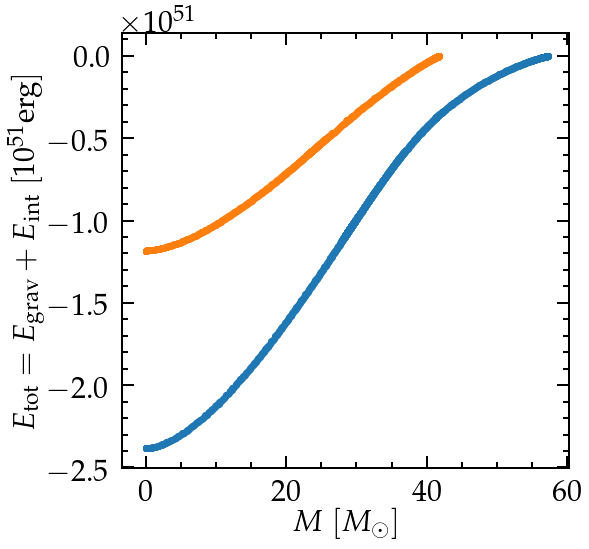

In [6]:
def Egrav(m, dm, r):
    """ returns gravitational binding energy profile """
    return np.cumsum(-G_cgs*m*dm/r)

def Etot(m, dm, e,r):
    """ total energy as gravitational+internal energy """
    E_grav = Egrav(m, dm, r)
    Etot = E_grav+e
    return Etot


fig=plt.figure()
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:,:])
# ax.scatter(m1/Msun, Etot(m1, dm1, e1, r1)/1e51)
# ax.scatter(m2/Msun, Etot(m2, dm2, e2, r2)/1e51) 
ax.scatter(m1/Msun, Egrav(m1, dm1, r1))
ax.scatter(m2/Msun, Egrav(m2, dm2, r2))
ax.set_xlabel(r"$M \ [M_\odot]$")
ax.set_ylabel(r"$E_\mathrm{tot} = E_\mathrm{grav}+E_\mathrm{int} \ [10^{51}\mathrm{erg}]$")

2.087811461056396e-11


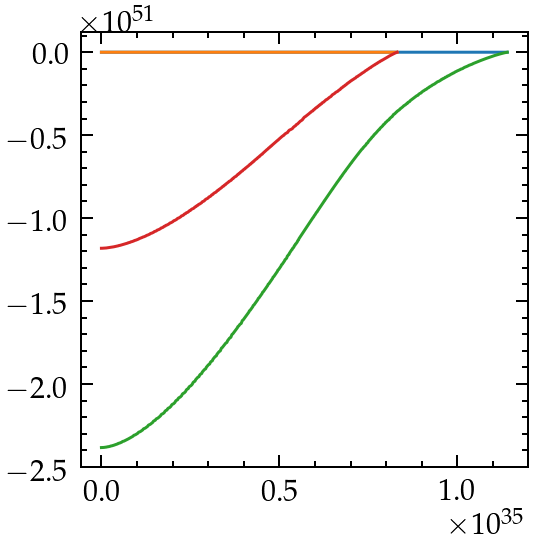

In [13]:
def Energetic_estimate_mass_loss(m1, dm1, e1, r1,m2, dm2, e2, r2, v_dispersion = 10, efficiency=0.5):
    """
    Yan-Fei's idea: compare the variation in kinetic energy to the energy profile of the 2 stars
    assume a fraction of that goes into thermal energy of the merger, how much mass can you lift?

    This is an order of magnitude estimate only!!!


    v_dispersion =  velocity dispersion of the cluster
    efficiency = efficiency of converting kinetic energy to thermal energy in the stars
    """
    M1 = max(m1)
    M2 = max(m2)
    mu = M1*M2/(M1+M2)
    # assume the dispersion velocity is the relative velocity between the 2 stars
    E_kin = 0.5*mu*v_dispersion*v_dispersion
    E_injected = E_kin*efficiency
    # get total energies (grav+internal) of the stars
    Etot1 = Etot(m1, dm1, e1,r1)
    Etot2 = Etot(m2, dm2, e2,r2)
    # chip away mass, removing the least bound cell of either stars
    DM = 0
    i = 0    
    while (E_injected> 0) and (i in range(max(len(dm2), len(dm1)))):
        if Etot1[i] > Etot2[i]:
            # less bound star 2
            # increase mass lost
            DM += dm2[i]
            # use some energy
            E_injected = E_injected - np.absolute(Etot2[i])
        else:
            # less bound star 1
            # increase mass lost
            DM += dm1[i]
            # use some energy
            E_injected = E_injected - np.absolute(Etot1[i])
        # print(E_injected, M1+M2)
        i+=1
        return DM
    
fig=plt.figure()
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:,:])
ax.plot(m1, e1)
ax.plot(m2, e2)
ax.plot(m1, Etot(m1, dm1, e1,r1))
ax.plot(m2, Etot(m2, dm2, e2,r2))
DM = Energetic_estimate_mass_loss(m1, dm1, e1, r1,m2, dm2, e2, r2, v_dispersion = 10, efficiency=1)
DM = DM/Msun
print(DM)

In [7]:
def get_radius_mass_percentile(m,r, p=0.5):
    """ returns the radius enclosing the percentile of the total mass """
    m_target = max(m)*p
    i = np.argmin(np.absolute(m-m_target))
    return r[i]


# test
# fig=plt.figure()
# gs = gridspec.GridSpec(100, 100)
# ax = fig.add_subplot(gs[:,:])
# ax.plot(r1, m1)

# r50 = get_radius_mass_percentile(m1, r1, p=0.5)
# ax.axvline(r50,0,1)
# ax.axhline(max(m1)/2, 0,1)
# ax.set_xlabel(r"$R \ [R_\odot]$")
# ax.set_ylabel(r"$M \ [M_\odot]$")

In [5]:
def Glebbeek2013_mass_loss(M1, M2):
    """
    estimate of *total* mass loss during a collision from Glebbeek et al. 2013
    see their sec. 4.1 --  tends to be underestimate and applies to head on collisions (b=0)

    M1, M2 total masses of the two stars -- implicitly assumes impact parameter is zero
    """
    C2 = 0.3
    q = M1/M1
    return C2*q/(1+q)**2

/home/math/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


/home/math/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


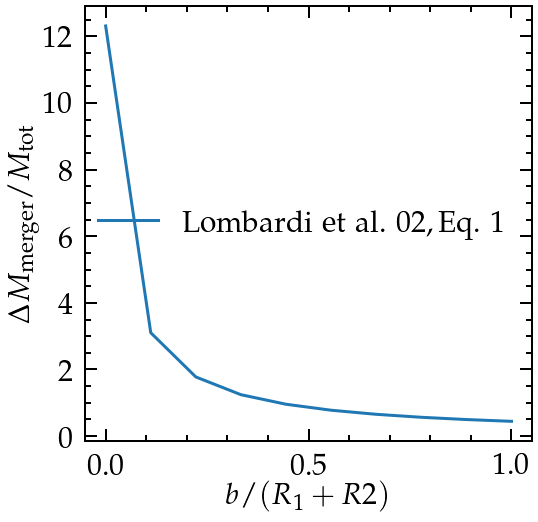

In [16]:
def Lombardi2002_mass_loss(m1, m2, r1, r2, rp):
    """
    estimate of *total* mass loss during a collision from Lombardi et al. 2002
    see their sec. 2.1

    m1, m2, r1, r2 are masses and radii of the input stellar models
    rp periastron separation of the parabolic orbit - NB: all orbits can be considered parabolic because of sigma_v <<v_esc,*
    """
    # define fitting constants
    c1 = 0.157
    c2 = 1.8
    # total masses of the two stars
    M1 = max(m1)
    M2 = max(m2)
    # reduced mass
    mu = M1*M2/(M1+M2)
    # get radii enclosing some percentage of the mass
    R1_86 = get_radius_mass_percentile(m1, r1, p=0.86)
    R2_86 = get_radius_mass_percentile(m2, r2, p=0.86)
    R1_05 = get_radius_mass_percentile(m1, r1, p=0.5)
    R2_05 = get_radius_mass_percentile(m2, r2, p=0.5)
    fl = c1*(mu/(M1+M2))*(R1_86+R2_86)/(R1_05+R2_05+c2*rp)
    return (M1+M2)*fl

# estimate for rp --  based on table 2 of Lombardi et al. 2002
fraction = np.linspace(0,1,10)
rp = fraction*(max(r1)+max(r2))
dm = np.zeros(len(rp))
for i in range(len(rp)):
    dm[i] = Lombardi2002_mass_loss(m1, m2, r1, r2, rp[i])/Msun
    
fig=plt.figure()
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:,:])
ax.plot(fraction,dm, label=r"$\mathrm{Lombardi\ et\ al.\ 02, Eq.~1}$")
# ax.axhline(Glebbeek2013_mass_loss(max(m1), max(m2)), 0,1, c='r', label=r"Glebbeek\ et\ al.\ 2013, Eq.~4")

# ax.set_yscale('log')
ax.set_xlabel(r"$b/(R_1+R2)$")
ax.set_ylabel(r"$\Delta M_\mathrm{merger}/M_\mathrm{tot}$")
ax.legend(loc="upper right", handlelength=0.5)
plt.savefig("/home/math/Documents/Research/Talks/2021/HUJI_colloquium/slides/fig_slides/lombardi_dm.pdf")